# Tabular Playground September 2021

# Load Data

In [1]:
import numpy as np
import pandas as pd
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

In [2]:
lst_train_dtypes = train.dtypes.value_counts()
print(lst_train_dtypes)

float64    118
int64        2
dtype: int64


All features are float and the index and 'claim' columns are int.  'claim' is the target variable.

# EDA

## Histograms

Taking a quick look at histograms of each feature.

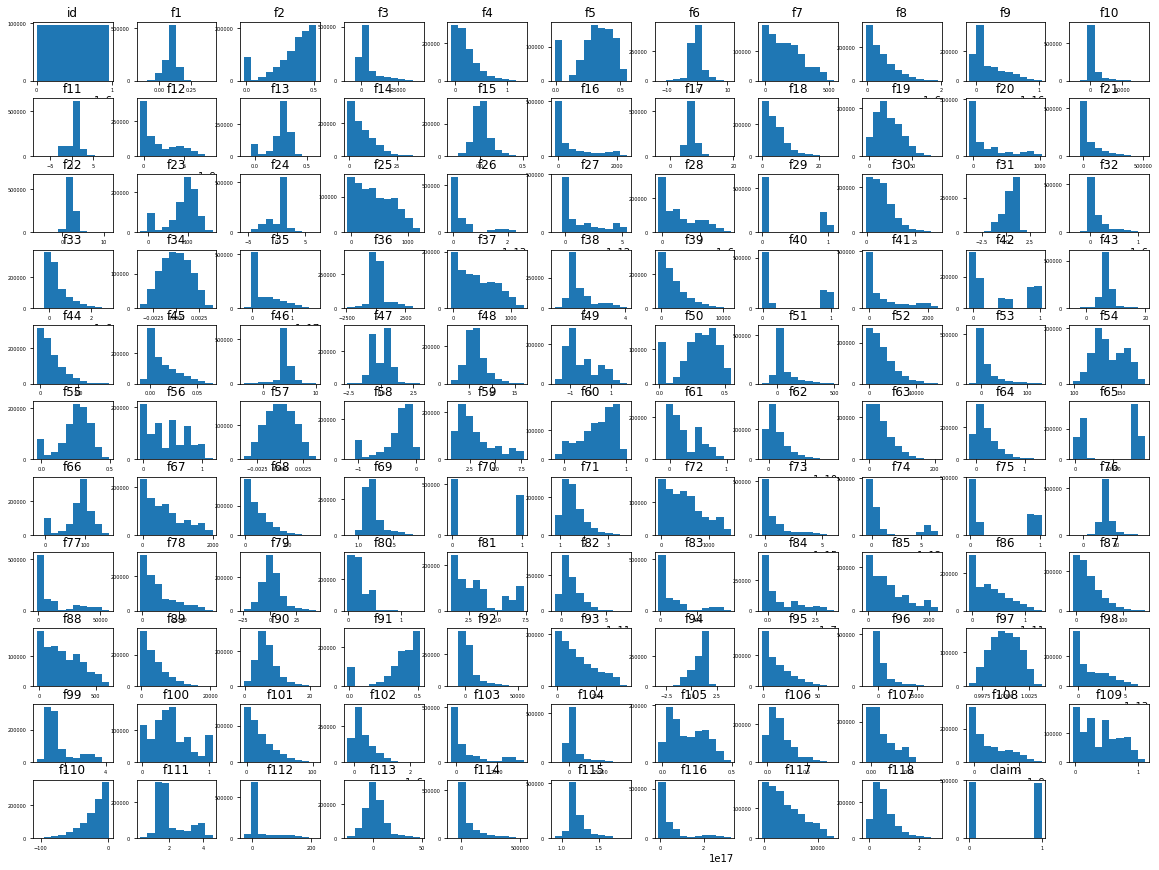

In [3]:
import matplotlib.pyplot as plt
train.hist(figsize=(20,15), grid=False, ylabelsize=5, xlabelsize=5)
plt.show()

There is an extremely wide range of values beween features, spanning orders of magnitude, so some standardization or normalization will be key.  Some appear to be very discrete, e.g. `f40`, `f42`, and so imputation with mean or median may not make sense.

## Missing Values

In [4]:
rows_with_na = train.shape[0] - train.dropna(axis=0).shape[0]
print("There are", rows_with_na, "rows with at least one missing value, out of", train.shape[0], "total rows in the training set.")

There are 598455 rows with at least one missing value, out of 957919 total rows in the training set.


There are many missing values in the dataset, more than half of the rows contain at least one missing value.  I'll now take a quick look at number of missing values per row.

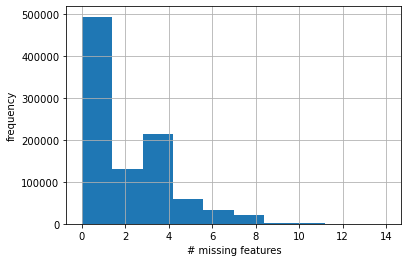

In [5]:
X_train = train.copy()
X_train['num_nan'] = X_train.isnull().sum(axis=1)
X_train.num_nan.hist()
plt.xlabel('# missing features')
plt.ylabel('frequency')
plt.show()

And also looking at the features which are most frequently missing.

In [6]:
feat_nan = train.isnull().sum(axis=0)
feat_nan.sort_values(ascending=False)

f31      15678
f46      15633
f24      15630
f83      15627
f68      15619
         ...  
f104     15198
f2       15190
f102     15168
id           0
claim        0
Length: 120, dtype: int64

All in all, the missing values are fairly evenly spread throughout all features at ~15,000 per feature.  Since there are so many missing values, I will add `num_nan` as a new feature in the FE section below.

# Feature Engineering

In a separate notebook, I've investigated the features using Mutual Information and PCA.  The MI analysis showed that none of the features had a very strong score and the PCA from all features resulted in no potential for dimensionality reduction due to a lack of variation extraction from the PCs, e.g. the percent of variance explained per PC increased linearly.  Because of this, I will add a few features to the dataset and evaluate their usefulness, including:

* `num_nan` - a count of missing values per row
* `sum` - a sum of all features after standardization, excluding missing values.  I plan to use an tree model which can have trouble splitting on a combination of a large number of variables, so this may prove to be a useful feature.
* some other descriptive stats just for completeness sake.

These will be built into the preprocessing pipeline with a custom class so that I can tune their selection like a hyperparameter.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    #one hyperparameter per new feature
    def __init__(self, add_sum = True, add_num_nan = True): #no *args or **kargs
        self.add_sum = add_sum
        self.add_num_nan = add_num_nan
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X):
        #generate additional features
        if self.add_sum:
            std_scaler = StandardScaler()
            sum_col = X.copy()
            sum_col[np.isnan(sum_col)] = 0
            sum_col = std_scaler.fit_transform(sum_col)
            sum_col = sum_col.sum(axis=1)
            X = np.c_[X, sum_col]
        if self.add_num_nan:
            num_nan = np.isnan(X).sum(axis=1)
            X = np.c_[X, num_nan]
        return X



In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

add_num_nan = True
add_sum = True

prep_pipeline = Pipeline([
    ('attr_adder', CombinedAttributesAdder(add_num_nan=add_num_nan, add_sum=add_sum)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

Now splitting the dataset into train, validation and taking a quick look at the new features.

In [9]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(train, test_size=0.1)

X_train_prep = train_set.drop(['id', 'claim'], axis=1)
y_train = train_set.claim

#keep track of feature names
X_features = X_train_prep.columns.values.tolist()
if add_sum:
    X_features += ['sum']
if add_num_nan:
    X_features += ['num_nan']

#preprocess
X_train_prep = prep_pipeline.fit_transform(X_train_prep)
#convert to dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=X_features)

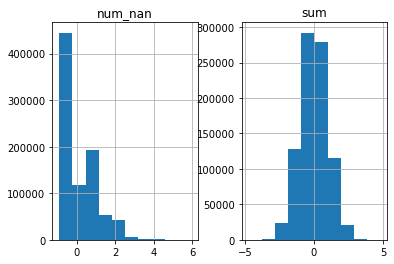

In [10]:
X_train_prep[['num_nan', 'sum']].hist()
plt.show()

The `num_nan` histogram looks identical to the exploratory figure above, meaning the pipeline is working as expected.  The `sum` feature appears normally distributed, which is interesting.  Of course, both features have been standardized after their creation so the values aren't as intuitive.  Now I'm going to see if either of these features have any predictive value (MI) or potential for dimensionality reduction (PCA).

## Mutual Information

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.  Mutual information can capture any kind of association (not just linear, like correlation).  Here are some things to remember when applying mutual information:

* MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
* The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [11]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [12]:
mi_scores = make_mi_scores(X_train_prep, y_train)

In [13]:
mi_scores.head(10)

num_nan    0.199673
sum        0.005163
f40        0.003246
f42        0.003206
f78        0.003061
f63        0.003038
f94        0.003028
f4         0.003004
f50        0.002988
f19        0.002981
Name: MI Scores, dtype: float64

In [22]:
mi_scores.tail(5)

f79     0.001035
f60     0.000987
f71     0.000985
f55     0.000759
f112    0.000638
Name: MI Scores, dtype: float64

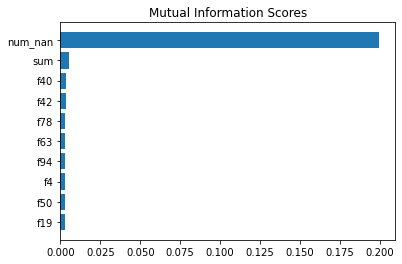

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores.head(10))

Surprisingly, it seems like the most promising feature is `num_nan`, or the number of missing features per row.  This also suggests to me that I may have to revisit how I'm imputing missing values, since they appear to be so important.  `sum` is the second most promising feature, albeit far behind `num_nan` in MI score.  Other than `num_nan` all other features have low MI scores, though none are zero.

In [15]:
zero_mi_scores = mi_scores[mi_scores == 0]
zero_mi_scores.shape
print(zero_mi_scores.shape[0], "of the", mi_scores.shape[0], "features have MI scores equal to zero")

0 of the 120 features have MI scores equal to zero


### Visualize MI

Now taking a look at the three most informative features.

C:\Python\Miniconda\envs\test-env\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Python\Miniconda\envs\test-env\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Python\Miniconda\envs\test-env\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Python\Miniconda\envs\test-env\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\P

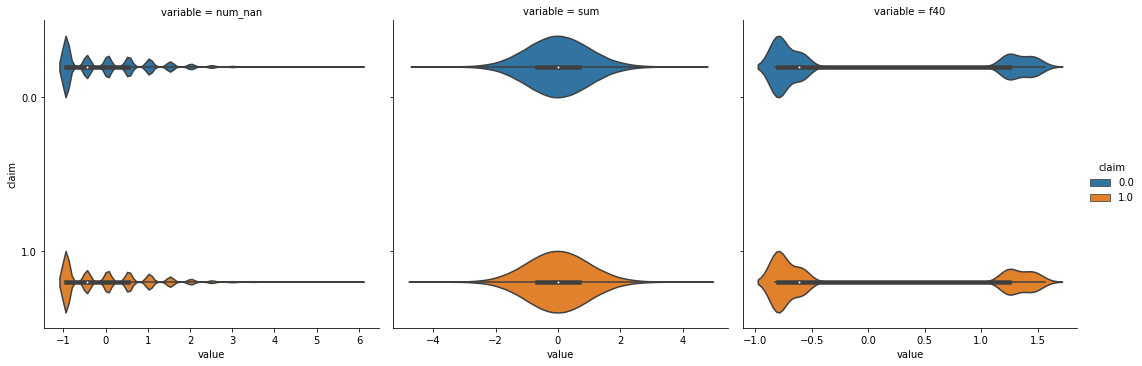

In [16]:
best_mi_features = mi_scores.iloc[:3].index.values.tolist()
plot_df = X_train_prep.copy()
plot_df['claim'] = y_train
plot_df = plot_df.melt(id_vars='claim', value_vars=best_mi_features)
plot_df['claim'] = plot_df.claim.astype('category')
sns.catplot(x="value", y="claim", col="variable", data=plot_df, hue="claim", kind="violin", sharex=False);

# PCA & Feature Selection

In an attempt to reduce dimensionality, I'm now going to run a PCA on all of the features.  I'll then select an appropriate number of PCs to include in the final model directly, adding the PCA to my final pipeline.

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
#running with the 10 most promising features
best_mi_features = mi_scores.iloc[:10].index.values.tolist()
X_pca = pca.fit_transform(X_train_prep[best_mi_features])

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [18]:
#function for plotting explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

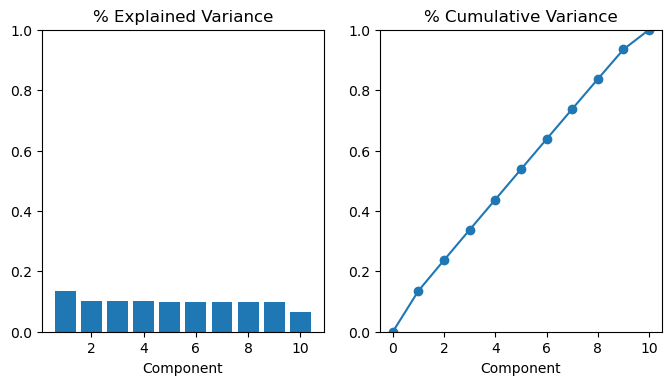

In [19]:
plot_variance(pca)
plt.show()

The first component explains slightly more variance than the subsequent components, but the PCs are mostly linear and therefore not very useful for dimensionality reduction.

# Baseline Models

As a baseline performance check, I'm going to try a few models and see what kind of auc scores I get.  I'll handle hyperparameter tuning in another notebook, as it'll be very resources hungry.

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression()

# #evaluating auc on the training set
log_reg.fit(X_train_prep, y_train)
predictions = log_reg.predict(X_train_prep)
log_reg_tr_auc = roc_auc_score(y_train, predictions)

#evaluating auc using cv
log_reg_cv_scores = cross_val_score(log_reg, X_train_prep, y_train,
                        scoring = 'roc_auc', cv=10)

#evaluating against validation set
X_valid_prep = valid_set.drop(['id', 'claim'], axis=1)
y_valid = valid_set.claim
X_valid_prep = prep_pipeline.transform(X_valid_prep)
preds_valid = log_reg.predict(X_valid_prep)
log_reg_valid_auc = roc_auc_score(y_valid, preds_valid)

#quick function to display scores
def display_scores(cv_scores, tr_score, valid_score):
    print("Training Score:", tr_score)
    print("CV Scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    print("StDev CV Scores:", cv_scores.std())
    print("Validation Score:", valid_score)

display_scores(log_reg_cv_scores, log_reg_tr_auc, log_reg_valid_auc)

Training Score: 0.7374653991714596
CV Scores: [0.79954176 0.79776402 0.79595872 0.79773838 0.79843598 0.79909284
 0.79878519 0.80162782 0.80233272 0.79710353]
Mean CV Score: 0.7988380980819616
StDev CV Scores: 0.0018542382769735487
Validation Score: 0.7388715411006335


# Evaluation

Now to predict the test set with the final model and submit predictions.

In [21]:
final_mod = log_reg

# Preprocessing of test data, get predictions
X_test_ids = test.id
X_test_prep = test.drop('id', axis=1)
X_test_prep = prep_pipeline.transform(X_test_prep)
preds_test = final_mod.predict(X_test_prep)

#export predictions
output = pd.DataFrame({'id': X_test_ids,
                       'claim': preds_test})
output.to_csv('submission.csv', index=False)